In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
rows = 10
cols = 10

# Q1) Creating reward functions and the heatmap

In [3]:
reward_function_1 = [[0.0 for x in range(cols)] for y in range(rows)]
reward_function_2 = [[0.0 for x in range(cols)] for y in range(rows)]
reward_function_1[rows - 1][cols - 1] = 1.0
reward_function_1 = np.array(reward_function_1)
reward_function_2 = np.array(reward_function_2)
reward_function_2[1:7,4] = -100.0
reward_function_2[1,5] = -100.0
reward_function_2[1:4,6] = -100.0
reward_function_2[7:9,6] = -100.0
reward_function_2[3,7] = -100.0
reward_function_2[7,7] = -100.0
reward_function_2[3:8,8] = -100.0
reward_function_2[9,9] = 10.0

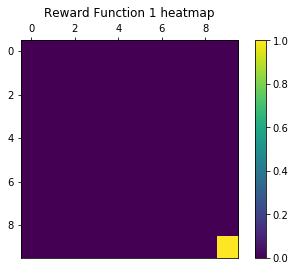

In [4]:
plt.imshow(reward_function_1)
ax = plt.gca()
plt.colorbar()
plt.title('Reward Function 1 heatmap', y = 1.08)
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top')


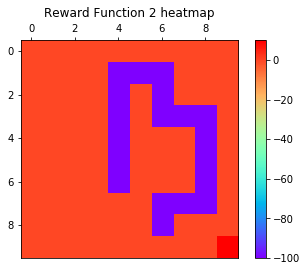

In [7]:
plt.imshow(reward_function_2, cmap = plt.cm.rainbow)
ax = plt.gca()
plt.colorbar()
plt.title('Reward Function 2 heatmap', y = 1.08)
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top')


# 2 Creating the environment for the agent

In [8]:
#Utility functions for the environment setup

def get_neighbors(state, rows, cols):
    left = state - rows
    
    right = state + rows
    
    #for states in last col
    if(right > rows*cols - 1):
        right = -1
    
    #for states in first row
    if(state % rows == 0):
        up = -1
    else:
        up = state - 1
    
    #for states in last row
    if(state % rows == rows -1):
        down = -1
    else:
        down = state + 1
    
    return {'L':left,'R':right,'U':up,'D': down}

def assign_prob(current_state, neighbors, action, wind_prob):

    current_state_prob = 0.0
    result_prob = {}
    for action_neigh in neighbors.keys():
        goto_state = neighbors[action_neigh]
        if(action_neigh == action):
            
            if(goto_state < 0):
                current_state_prob = current_state_prob + 1 - wind_prob + (wind_prob/4)
                result_prob[action_neigh] = 0.0
            else:
                result_prob[action_neigh] = 1 - wind_prob + (wind_prob/4)
        
        else:
            
            if(goto_state < 0):
                current_state_prob = current_state_prob + (wind_prob/4)
                result_prob[action_neigh] = 0.0
            else:
                result_prob[action_neigh] = wind_prob / 4
                
    result_prob['C'] = current_state_prob
    return result_prob
                

In [9]:
#Value iteration algorithm
def value_iteration_algo(num_states, action_set, transition_probabilities, 
                         reward_function, estimation_epsilon, discount_factor):

    #initialization
    value_state = [0.0 for state in range(num_states)]

    delta = math.inf
    #Estimation
    while(delta > estimation_epsilon):
        delta = 0
        for curr_state in range(num_states):

            value = value_state[curr_state]
            temp_value = -math.inf
            for action in action_set:
                transition_vector = transition_probabilities[action][curr_state]
                reward_vector = reward_function
                temp_value = max(temp_value, 
                                 value_iteration_comp(num_states,transition_vector, reward_vector, discount_factor, value_state))

            value_state[curr_state] = temp_value
            delta = max(delta, abs(value - value_state[curr_state]))

    pi_state = [0.0 for state in range(num_states)]

    #Computation
    for curr_state in range(num_states):
            temp_action = 'C'
            temp_value = -math.inf
            for action in action_set:
                transition_vector = transition_probabilities[action][curr_state]
                reward_vector = reward_function
                if value_iteration_comp(num_states,transition_vector, reward_vector, discount_factor, value_state) > temp_value:
                    temp_action = action
                    temp_value = value_iteration_comp(num_states,transition_vector, reward_vector, discount_factor, value_state)

            pi_state[curr_state] = temp_action

    #Return the optimal value policies and the actions
    return [value_state, pi_state]

    
#value iteration algo helper         
def value_iteration_comp(num_states, transition_vector, reward_vector, discount_factor, value_state):
    new_value_state = 0
    
    for i in range(num_states):
        new_value_state = new_value_state + (transition_vector[i] * (reward_vector[i] + (discount_factor * value_state[i])))
        
    return new_value_state

In [10]:
#Environment setup starts here:
grid_space = [[0.0 for x in range(cols)] for y in range(rows)]
for j in range(rows):
    for i in range(cols):
        grid_space[j][i] = i * 1.0 * rows + j

In [11]:
# Just a fun way to visualize the 100 states in a 10 X 10 grid
grid_space = np.array(grid_space)
#Total number of possible states
num_states = rows * cols  #100 for this case

#Total possible actions (up, left, Right, Down)
action_set = ['U','L','R','D']

#Number of actions
action_num = len(action_set)

#Wind probability w
wind_prob = 0.1

#Discount factor (gamma in the range [0,1) )
discount_factor = 0.8

#Setting up the transition matrix. We have a dictionary for the key being each action in our action set and the value
#being a 100 X 100 matrix denoting the probability of moving from any node i to j given that action
transition_probabilities = {}

for action in action_set:
    
    transition_matrix = [[0.0 for i in range(num_states)] for j in range(num_states)]
    
    for i in range(num_states):
        neighbors_i = get_neighbors(i, rows, cols)
        probs = assign_prob(current_state = i, neighbors = neighbors_i, action = action, wind_prob = wind_prob)
        for key in probs.keys():
            if(key == 'C'):
                transition_matrix[i][i] = probs[key]
            else:
                new_state = neighbors_i[key]
                if(new_state >= 0):
                    transition_matrix[i][new_state] = probs[key]
    
    transition_probabilities[action] = transition_matrix
        

In [12]:
#Reward function (in this case a vector as it depends only on end state) for this computation
reward_function = reward_function_1.flatten('F')
estimation_epsilon = 0.01
[value_state,pi_state] = value_iteration_algo(num_states, action_set, transition_probabilities, 
                                              reward_function, estimation_epsilon, discount_factor)

# Result for q2, q3

In [13]:
optimal_value_state = np.asarray(value_state)
optimal_value_state = np.reshape(optimal_value_state, (rows,cols), order = 'F')

          0         1         2         3         4         5         6  \
0  0.041796  0.062838  0.089742  0.123849  0.167081  0.221883  0.291354   
1  0.062838  0.087870  0.121557  0.164514  0.219246  0.288990  0.377871   
2  0.089742  0.121557  0.164390  0.219132  0.288903  0.377826  0.491156   
3  0.123849  0.164514  0.219132  0.288900  0.377825  0.491159  0.635601   
4  0.167081  0.219246  0.288903  0.377825  0.491159  0.635603  0.819695   
5  0.221883  0.288990  0.377826  0.491159  0.635603  0.819696  1.054322   
6  0.291354  0.377871  0.491156  0.635601  0.819695  1.054322  1.353351   
7  0.379420  0.491061  0.635490  0.819610  1.054265  1.353324  1.734461   
8  0.490983  0.633219  0.817355  1.052191  1.351572  1.733180  2.219527   
9  0.609648  0.787354  1.018597  1.315059  1.695073  2.182231  2.806802   

          7         8         9  
0  0.379420  0.490983  0.609648  
1  0.491061  0.633219  0.787354  
2  0.635490  0.817355  1.018597  
3  0.819610  1.052191  1.315059  
4  1

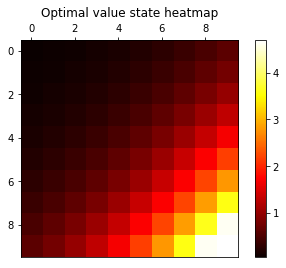

In [14]:
df = pd.DataFrame(optimal_value_state, columns = [i for i in range (cols)], index = [j for j in range(rows)])
print(df)
#NEED TO PLOT OPTIMAL VALUE PROPERLY
#ASK HEATMAP
#GENERATE HEATMAP
plt.imshow(optimal_value_state, cmap = 'hot')
ax = plt.gca()
plt.colorbar()
plt.title('Optimal value state heatmap', y = 1.08)
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top')


# Do 4
# 5 result here

In [15]:
optimal_value_action = np.asarray(pi_state)

#Convert char to arrow
for i in range(len(optimal_value_action)):
    action = optimal_value_action[i]
    if action == 'U':
        optimal_value_action[i] = '↑'
    elif action == 'D':
        optimal_value_action[i] = '↓'
    elif action == 'R':
        optimal_value_action[i] = '→'
    elif action == 'L':
        optimal_value_action[i] = '←'
        
optimal_value_action = np.reshape(optimal_value_action, (rows,cols), order = 'F')

df = pd.DataFrame(optimal_value_action, columns = [i for i in range (cols)], index = [j for j in range(rows)])
df

#NEED TO PLOT OPTIMAL VALUE PROPERLY
#ASK HEATMAP
#GENERATE HEATMAP


,0,1,2,3,4,5,6,7,8,9
0,→,→,→,→,→,→,→,↓,↓,↓
1,↓,→,→,→,→,→,↓,↓,↓,↓
2,↓,↓,→,→,→,↓,↓,↓,↓,↓
3,↓,↓,↓,↓,↓,↓,↓,↓,↓,↓
4,↓,↓,↓,→,↓,↓,↓,↓,↓,↓
5,↓,↓,→,→,→,↓,↓,↓,↓,↓
6,↓,→,→,→,→,→,↓,↓,↓,↓
7,→,→,→,→,→,→,→,→,↓,↓
8,→,→,→,→,→,→,→,→,→,↓
9,→,→,→,→,→,→,→,→,→,→


In [16]:
#Reward function (in this case a vector as it depends only on end state) for this computation
reward_function = reward_function_2.flatten('F')
estimation_epsilon = 0.01
[value_state,pi_state] = value_iteration_algo(num_states, action_set, transition_probabilities, 
                                              reward_function, estimation_epsilon, discount_factor)

# Result for q6,7

In [17]:
optimal_value_state = np.asarray(value_state)
optimal_value_state = np.reshape(optimal_value_state, (rows,cols), order = 'F')

          0         1         2          3          4          5          6  \
0  0.648477  0.794107  0.825238   0.536246  -2.370432  -4.233817  -1.920530   
1  0.829852  1.021236  1.066033  -1.867904  -6.738219  -8.673754  -6.369795   
2  1.063610  1.316513  1.450077  -1.624025  -6.741509 -13.911182  -9.649225   
3  1.360252  1.692699  1.948023  -1.232169  -6.323085  -7.977606  -7.936680   
4  1.736572  2.171602  2.589833  -0.725587  -5.830730  -3.253626  -3.230200   
5  2.213933  2.781084  3.417100  -0.027563  -5.098662  -0.549015  -0.476653   
6  2.819423  3.556504  4.482395   3.028072   2.484033   2.884093  -0.454636   
7  3.587378  4.542737  5.796132   7.291987   6.722347   7.244849   0.941170   
8  4.561331  5.798264  7.400767   9.443019  12.011765  12.892754  17.101043   
9  5.730000  7.319638  9.391159  12.048251  15.455919  19.827538  25.501069   

           7          8          9  
0   1.131108   1.594356   2.038207  
1  -1.294796   1.928343   2.610469  
2  -5.511043  -0.13

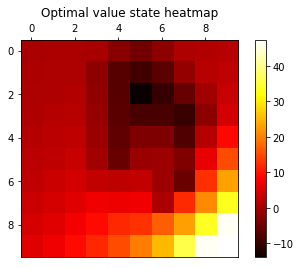

In [18]:
df = pd.DataFrame(optimal_value_state, columns = [i for i in range (cols)], index = [j for j in range(rows)])
print(df)
#NEED TO PLOT OPTIMAL VALUE PROPERLY
#ASK HEATMAP
#GENERATE HEATMAP
plt.imshow(optimal_value_state, cmap = 'hot')
ax = plt.gca()
plt.colorbar()
plt.title('Optimal value state heatmap', y = 1.08)
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top')


In [19]:
optimal_value_action = np.asarray(pi_state)

#Convert char to arrow
for i in range(len(optimal_value_action)):
    action = optimal_value_action[i]
    if action == 'U':
        optimal_value_action[i] = '↑'
    elif action == 'D':
        optimal_value_action[i] = '↓'
    elif action == 'R':
        optimal_value_action[i] = '→'
    elif action == 'L':
        optimal_value_action[i] = '←'
        
optimal_value_action = np.reshape(optimal_value_action, (rows,cols), order = 'F')

df = pd.DataFrame(optimal_value_action, columns = [i for i in range (cols)], index = [j for j in range(rows)])
df

#NEED TO PLOT OPTIMAL VALUE PROPERLY
#ASK HEATMAP
#GENERATE HEATMAP


,0,1,2,3,4,5,6,7,8,9
0,↓,↓,↓,←,←,→,→,→,→,↓
1,↓,↓,↓,←,←,↑,→,→,→,↓
2,↓,↓,↓,←,←,↓,→,→,→,↓
3,↓,↓,↓,←,←,↓,↓,↑,→,↓
4,↓,↓,↓,←,←,↓,↓,↓,→,↓
5,↓,↓,↓,←,←,↓,↓,←,→,↓
6,↓,↓,↓,↓,↓,↓,←,←,→,↓
7,↓,↓,↓,↓,↓,↓,←,↓,↓,↓
8,→,→,→,↓,↓,↓,↓,↓,↓,↓
9,→,→,→,→,→,→,→,→,→,→
